# Analysis

In this notebook, we will work on data normalization and feature selection (highly variable gene selection) in scRNA-seq data. We will load the saved processed data and proceed.


## Load necessary packages

In [81]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

## Load the processed data (see session-1 for the file)

In [39]:
adata = sc.read_h5ad('/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/processed_adata.h5ad')

In [40]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'

# Data normalization

A note based on what I have learned so far: "A common artefact in data analysis is to have cellular heterogeneity strongly correlated with sequencing depth. This can be observed by visualizing library size on a low-dimensional representation of the data (UMAP or tSNE). Since we assume that the majority of biological variation should not be driven by sequencing depth bias, it is of interest to address this issue by normalizing the cells".
I will use the median library size normalization. 

## Median Library Size Normalization

Notes: "One of the most common normalization methods is median library size normalization followed by log-transformation. Median library size normalization is inspired by normalization techniques in bulk data (Transcript Per Million or TPM normalization). This approach aims to normalize the library size of all cells to the same value, which is usually set to be the median library size in the data. The assumption here is that all cells in a sample should have the same total number of RNA counts. Obviously this is not necessarily an adequate assumption and in many circumstances is false (for example, a sample with cells of different sizes or at different stages of activation can have different total RNA). However, this is still the most common kind of normalization being used. 
The normalization step is followed by a log transformation of the data. This step is done primarily to normalize for the differences in gene expression scales. Of note, scRNA-seq data is massively undersampled, which means many of the entries are 0 thus taking log of the data can be problematic. As such, it is typical to add a non-zero pseudocount (typically 0.1 or 1) to the data. It is generally wise to ensure that zeros remain as zeros post log-transformation. So, it is common to add 1 to the data before taking log2 of the data: `adata.X = np.log2(adata.X + 1)` or adding and subtracting 0.1: `adata.X = np.log(adata.X + 0.1) - np.log(0.1)`. Either way, zeros before log remain as zeros".

"Before we apply this normalization step, one very important note on Scanpy's data structure: The main data on which processing is to be done is stored in adata.X. So if we normalize the data in place then the original raw data will be replaced by the new normalized counts and we will lose the original counts. To avoid this from happening, we will store the original raw counts in adata.layers as follows. It is wise to save original counts for later, as we may require them for downstream analysis (e.g. count based factor analysis methods)".

### Save in layers

In [41]:
adata.layers['raw_data'] = adata.X.copy()

In [42]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'
    layers: 'raw_data'

Now that we have made a copy of the original counts, we can go ahead and apply Scanpy's normalization function.

In [43]:
# Normalize the total counts per cell to ensure each cell has the same total count, 
# mitigating differences in sequencing depth across cells. This step adjusts gene expression values to be comparable across cells. 
sc.pp.normalize_total(adata, inplace=True)


In [44]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'
    layers: 'raw_data'

An extra step: Before we take log of the normalized counts, we can save the normalized counts in layers (just like we did for the original counts).

In [45]:
adata.layers['norm_counts'] = adata.X.copy()

In [46]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'
    layers: 'raw_data', 'norm_counts'

We can now log transform the data as follows:

In [48]:
sc.pp.log1p(adata)

In [49]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'
    uns: 'log1p'
    layers: 'raw_data', 'norm_counts'

In [50]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Highly Variable Genes

In [51]:
# Identify the top 2,000 highly variable genes from the raw data layer using the Seurat v3 method.
# This step selects genes with the greatest variation across cells, useful for clustering and reducing noise.
sc.pp.highly_variable_genes(adata, layer='raw_data', n_top_genes=2000, flavor='seurat_v3')


In [52]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_data', 'norm_counts'

In [54]:
# Display the columns related to highly variable genes in the variable (gene) metadata:
# - 'highly_variable': Boolean indicating whether each gene is among the selected highly variable genes.
# - 'highly_variable_rank': Rank of each highly variable gene based on variability (lower ranks are more variable).
# - 'means': Mean expression value of each gene across cells, used in identifying variability.
# - 'variances': Variance of each gene across cells, indicating the spread of expression.
# - 'variances_norm': Normalized variance, accounting for mean expression, to identify genes with meaningful variability.
adata.var[['highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm']]


,highly_variable,highly_variable_rank,means,variances,variances_norm
AL669831.5,False,NaN,0.059268,0.064099,0.808111
LINC00115,False,NaN,0.019478,0.021160,0.855170
FAM41C,False,NaN,0.021931,0.023414,0.837423
SAMD11,True,556.0,0.029585,0.087099,2.293107
NOC2L,False,NaN,0.364439,0.574209,0.812982
...,...,...,...,...,...
AL592183.1,False,NaN,0.091404,0.098754,0.765253
AC007325.4,False,NaN,0.017074,0.018844,0.875018
AL354822.1,False,NaN,0.022471,0.029327,1.022914
AC004556.1,False,NaN,0.155726,0.233047,1.000195


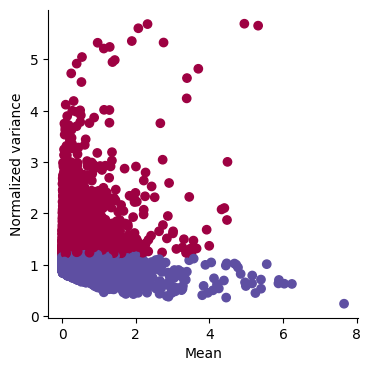

In [55]:
# Plot a scatter plot to visualize the relationship between gene expression mean and normalized variance.
# This helps in understanding how gene variability relates to average expression levels, highlighting the highly variable genes in the dataset.
# - x: Mean expression values for each gene (log-transformed to enhance visibility).
# - y: Normalized variance for each gene (also log-transformed).
# - colors: Color-codes points based on whether each gene is highly variable (True/False).

x = adata.var['means']  # Mean expression of each gene across cells
y = adata.var['variances_norm']  # Normalized variance of each gene across cells

colors = adata.var['highly_variable']  # Boolean indicating highly variable genes

# Create the scatter plot with log-transformed axes
plt.scatter(np.log2(x + 1), np.log2(y + 1), c=colors)
plt.xlabel('Mean')  # X-axis label for log-transformed mean expression
plt.ylabel('Normalized variance')  # Y-axis label for log-transformed normalized variance
plt.show()  # Display the plot


Color Coding:
Dark Red Dots: These are genes identified as highly variable, which means they exhibit greater variability in expression across cells. Highly variable genes are of interest in single-cell RNA-seq analysis as they may play roles in distinguishing different cell types or states.
Blue Dots: These are non-variable genes, exhibiting lower variability across cells. These genes are typically less informative for clustering and identifying cell types.

The plot shows that highly variable genes tend to have higher normalized variance, even at lower mean expression levels. This high variability indicates that these genes are differentially expressed across cell populations, making them valuable for downstream analyses like clustering and identifying distinct cell states or types.

# PCA

In [57]:
# Perform Principal Component Analysis (PCA) on the input data (adata)
# PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space, preserving the maximum variance
# n_comps=50 indicates that the algorithm will calculate 50 principal components, which can help capture significant patterns or features while reducing noise and dimensionality
# Setting use_highly_variable=None means the analysis will consider all features (genes), not just a subset with high variance, allowing the model to potentially capture a broader set of patterns
sc.tl.pca(adata, n_comps=50, use_highly_variable=None)


In [ ]:

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [58]:
# Build a K-nearest neighbors (KNN) graph on the data based on the PCA representation
# n_neighbors=30 defines the number of neighbors each cell will consider, which impacts the granularity of clustering and connectivity in the data
# use_rep='X_pca' indicates that the algorithm will use the PCA-reduced data as input, which is more efficient and reduces noise compared to using the original high-dimensional data
# metric='euclidean' specifies that the Euclidean distance metric will be used to calculate distances between cells in PCA space, which is common for continuous data
# key_added='neighbors_30' names the stored neighbors graph in the AnnData object, which can be used in subsequent analyses (like clustering or visualization)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')


In [59]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [60]:
# Access the distance matrix of the neighbors graph generated by the sc.pp.neighbors function
# 'neighbors_30_distances' contains the pairwise distances between each cell and its 30 nearest neighbors
# This matrix is useful for examining the actual distances used in building the neighborhood graph, which is a foundational structure for clustering and visualization techniques like UMAP or t-SNE.
adata.obsp['neighbors_30_distances']


<20382x20382 sparse matrix of type '<class 'numpy.float32'>'
	with 631842 stored elements in Compressed Sparse Row format>

In [61]:
# Access the connectivity matrix from the neighbors graph created by sc.pp.neighbors
# 'neighbors_30_connectivities' represents the adjacency matrix of the K-nearest neighbors graph, showing how strongly each cell is connected to its 30 nearest neighbors.
# This matrix is typically used in clustering and community detection algorithms, as well as in manifold learning.
adata.obsp['neighbors_30_connectivities']


<20382x20382 sparse matrix of type '<class 'numpy.float32'>'
	with 870868 stored elements in Compressed Sparse Row format>

# UMAP

In [62]:
# Perform UMAP dimensionality reduction on the data
# Using the 'neighbors_30' key to leverage the precomputed 30-nearest neighbors graph
# 'min_dist' controls how tightly UMAP clusters data points, with 0.1 allowing more clustering detail
sc.tl.umap(adata, neighbors_key='neighbors_30', min_dist=0.1)


In [74]:
adata

AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'umap_30_knn', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [64]:
adata.obsm['X_umap']

array([[ 9.967156 , -6.8564053],
       [ 4.3263273, 17.01892  ],
       [ 9.904691 , -6.255532 ],
       ...,
       [ 3.5886407, 12.448602 ],
       [ 5.768974 , 17.395748 ],
       [ 4.546    , 13.437656 ]], dtype=float32)

In [65]:
adata.obsm['X_umap'].shape

(20382, 2)

In [66]:
# Create a temporary UMAP projection of `adata` with the 30-nearest neighbors
# Setting `copy=True` ensures that `adata` itself isn't modified; instead, we get a copy of the UMAP embedding
adata_umap_temp = sc.tl.umap(adata, neighbors_key='neighbors_30', copy=True)

# Store the UMAP embedding from the temporary copy in the main `adata` object under `umap_30_knn`
adata.obsm['umap_30_knn'] = adata_umap_temp.obsm['X_umap']

# Clean up by deleting the temporary UMAP object to free memory
del adata_umap_temp

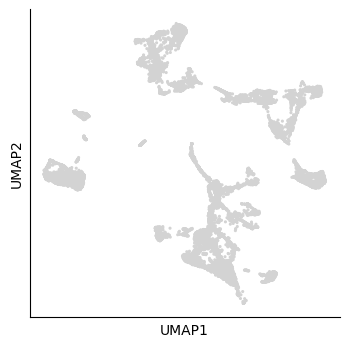

In [67]:
sc.pl.umap(adata, size = 20)

In [69]:
# Compute the 30-nearest neighbors on PCA-transformed data using Euclidean distance
# This step builds a nearest-neighbors graph in a lower-dimensional space (PCA), preserving local structure and enabling downstream tasks like clustering and visualization. 
# The neighbor graph is essential for methods like UMAP and graph-based clustering (e.g., Leiden or Louvain).
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')


In [70]:
# Perform UMAP and Force-Directed Layout (FDL) for dimensionality reduction and visualization
# Both UMAP and FDL use the precomputed nearest-neighbors graph ('neighbors_30') to create low-dimensional embeddings. UMAP captures local and global data structure, useful for clustering visualization, while FDL (using ForceAtlas2 layout) arranges data points in a graph structure, highlighting community structures. We might probably use just UMAP, but keeping the FDL in case for future use.
sc.tl.umap(adata, neighbors_key='neighbors_30', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='neighbors_30')


In [71]:
# Perform clustering using the PhenoGraph algorithm with specified parameters
# PhenoGraph is a graph-based clustering algorithm often used in single-cell analysis to identify clusters based on similarity in a neighborhood graph. Here, it uses the Leiden algorithm with 30 neighbors, a Jaccard similarity metric, and Euclidean distances to form clusters, capturing both local and global relationships in complex data. This approach enables high-resolution clustering of diverse cell populations.

sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=0.5)

# Convert the 'pheno_jaccard_ig' matrix to a sparse format for memory efficiency
import scipy
adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5842139720916748 seconds
Jaccard graph constructed in 3.6012489795684814 seconds
Running Leiden optimization
Leiden completed in 5.711572885513306 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.573473930358887 seconds


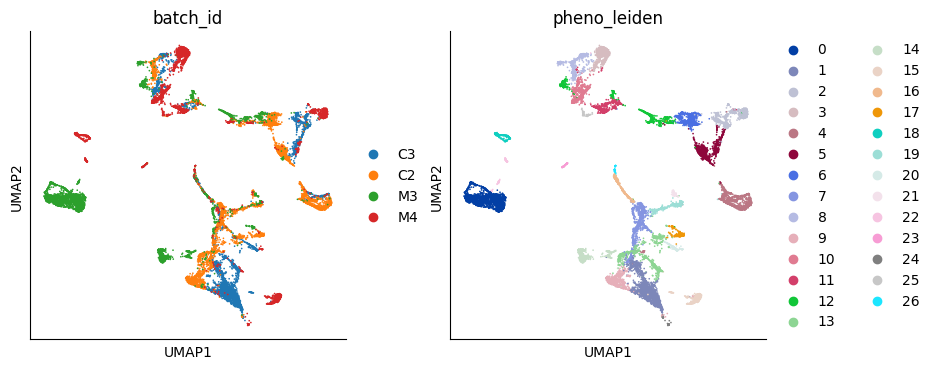

In [72]:
# Plot the UMAP embedding colored by batch ID and PhenoGraph-Leiden clustering labels
# Visualizing the UMAP with 'batch_id' helps assess the sample comparison in the data, while coloring by 'pheno_leiden' allows us to inspect the clustering results. This helps in validating the separation of clusters and checking if similar clusters are grouped, indicating meaningful biological or structural patterns captured by the model.
sc.pl.umap(adata, color=['batch_id', 'pheno_leiden'])


In [76]:
adata.obs.columns

Index(['batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo',
       'pheno_leiden'],
      dtype='object')

In [77]:
# Create a temporary DataFrame to store key metrics for each cell, extracted from the AnnData object
# This DataFrame consolidates features relevant to data quality and clustering analysis, such as the PhenoGraph-Leiden cluster assignment ('pheno_leiden'), mitochondrial content ('%-Mito'), library size (total counts per cell), and gene expression diversity (number of genes per cell). 
# These features can be useful for exploratory data analysis, quality control, and as potential predictors or covariates in downstream analyses.
df_temp = pd.DataFrame({
    'pheno_leiden': adata.obs['pheno_leiden'],  # Cluster assignments for each cell
    '%-Mito': adata.obs['pct_counts_mt'],       # Percentage of mitochondrial gene counts, an indicator of cell health
    'library_size': adata.obs['log1p_total_counts'],  # Log-transformed total counts, representing cell size or sequencing depth
    'n_genes_per_cell': adata.obs['log1p_n_genes_by_counts']  # Log-transformed count of genes per cell, indicating expression diversity
}, index=adata.obs.index)


/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/693190300.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/693190300.py:4: UserWarning: The palette list has more values (28) than needed (27), which may not be intended.
  sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/693190300.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "library_size", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/69319

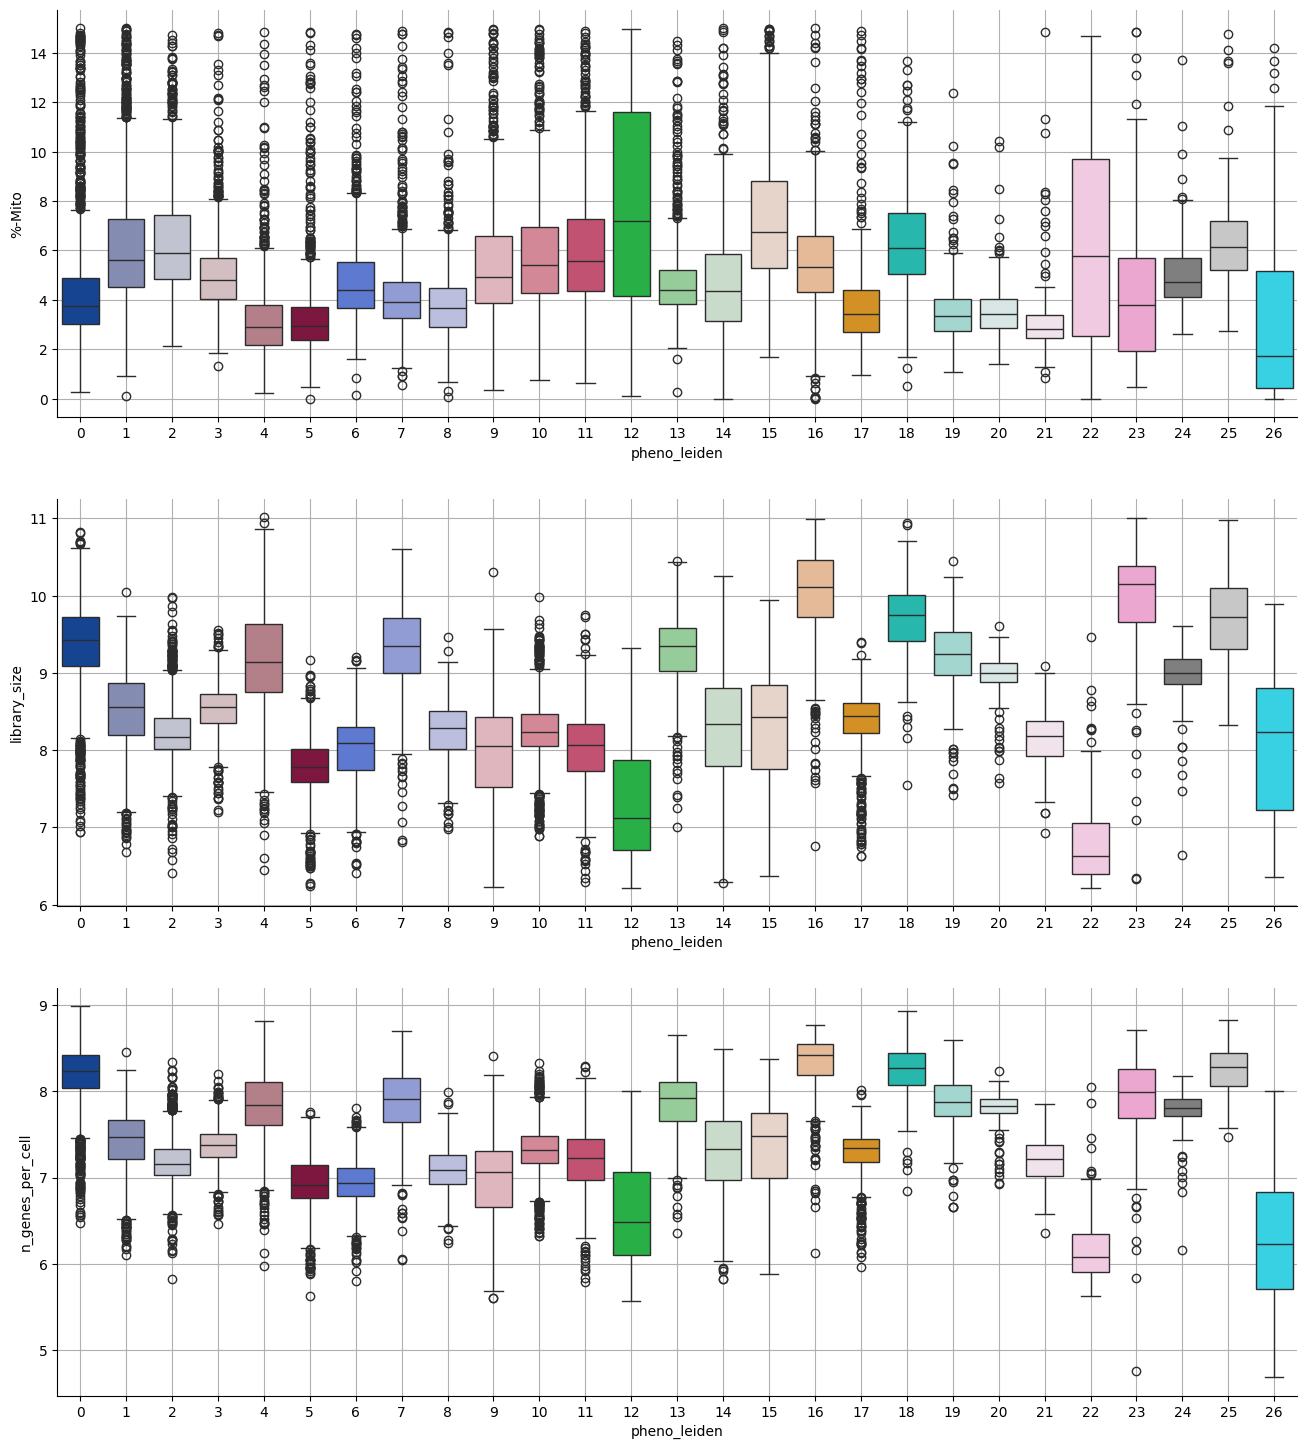

In [78]:
import seaborn as sns
fig = plt.figure(figsize = (8*2, 6*3))
ax = fig.add_subplot(3, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

ax = fig.add_subplot(3, 1, 2)
sns.boxplot(x = "pheno_leiden", y = "library_size", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

ax = fig.add_subplot(3, 1, 3)
sns.boxplot(x = "pheno_leiden", y = "n_genes_per_cell", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')


In [79]:
# Define the clusters you want to remove. Potential Removals:

# Clusters 12 and 13 for high mitochondrial content.
# Cluster 22 for low library size and low gene count per cell.

clusters_to_remove = [12, 13, 22]

# Filter out cells that are in these clusters
adata_filtered = adata[~adata.obs['pheno_leiden'].isin(clusters_to_remove)].copy()


In [82]:
adata_filtered

AnnData object with n_obs × n_vars = 18673 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'umap_30_knn', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

# Doublet Detection using Scrublet
Doublet detection using Scrublet is a machine-learning-based approach to identify and filter out doublets, which are artifacts in single-cell RNA sequencing (scRNA-seq) data. Doublets occur when two cells are captured together and sequenced as a single "cell," leading to mixed gene expression profiles that can distort downstream analyses like clustering, cell-type identification, and differential expression.

Scrublet applies a k-nearest neighbors (k-NN) algorithm to simulate doublets and then uses a classifier to identify cells with doublet-like gene expression profiles. From a machine learning perspective, this involves:

Data Augmentation: Simulating artificial doublets by combining expression profiles of two random cells.
Feature Engineering: Using gene expression profiles as features to distinguish between real cells and doublets.
Classification: A classifier (typically a probabilistic model) is trained to assign a likelihood score to each cell based on its similarity to simulated doublets.
In a data science context, Scrublet helps clean the dataset by removing noisy data points (doublets), thereby improving the accuracy of downstream models and analyses.

In [83]:
# Create a new AnnData object for Scrublet analysis using the raw data layer of the filtered dataset.
# This ensures that doublet detection is performed on the original gene expression data without any normalization or scaling applied. 'obs' and 'var' are carried over from the filtered AnnData object, preserving cell metadata and gene information.
adata_scrublet = sc.AnnData(adata_filtered.layers['raw_data'], obs=adata_filtered.obs, var=adata_filtered.var)


In [84]:
# Perform doublet detection using Scrublet on the AnnData object created for this purpose.
# 'sim_doublet_ratio' specifies the ratio of simulated doublets to observed cells to ensure sufficient data for training.
# 'expected_doublet_rate' sets an approximate rate of doublets expected in the data, informing Scrublet's predictions.
# 'knn_dist_metric' defines the distance metric ('euclidean' in this case) used for k-nearest neighbor (KNN) calculations.
# 'log_transform' applies log transformation to the data for Scrublet processing, improving signal-to-noise.
# 'n_prin_comps' specifies the number of principal components for dimensionality reduction, aiding in doublet identification.
# 'random_state' ensures reproducibility by setting a random seed for the simulation and neighbor calculation.
sc.external.pp.scrublet(adata_scrublet, sim_doublet_ratio=2.0, expected_doublet_rate=0.06,
                        knn_dist_metric='euclidean', log_transform=True, n_prin_comps=30, 
                        random_state=0)


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


In [85]:
adata_scrublet

AnnData object with n_obs × n_vars = 18673 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet'

In [86]:
# Retrieve the 'doublet_score' and 'predicted_doublet' columns from the adata_scrublet.obs dataframe.
# 'doublet_score' provides a numerical score for each cell, indicating the likelihood of it being a doublet.
# 'predicted_doublet' is a binary indicator (True/False) showing whether each cell is predicted as a doublet.
# These values help in identifying and potentially filtering out doublets, thus improving data quality for analysis.
adata_scrublet.obs[['doublet_score', 'predicted_doublet']]


,doublet_score,predicted_doublet
AAACCCAGTGAGTAGC-1-C3,0.014499,False
AAACCCAGTGTCGATT-1-C3,0.005411,False
AAACCCAGTTTCGACA-1-C3,0.012946,False
AAACCCATCACCCTGT-1-C3,0.027617,False
AAACCCATCACGGTCG-1-C3,0.008107,False
...,...,...
TTTGTTGAGGTGCAGT-1-M4,0.006051,False
TTTGTTGAGTAAGAGG-1-M4,0.006713,False
TTTGTTGCACGATTCA-1-M4,0.008107,False
TTTGTTGCACTCAAGT-1-M4,0.008107,False


In [87]:
# Access the 'scrublet' attribute in the uns (unstructured) dictionary of the adata_scrublet object.
# This attribute stores metadata related to the Scrublet analysis, such as parameters used, summary statistics, and diagnostic values. It helps to track and interpret the Scrublet results, including the configuration and outcomes of the doublet detection process.
adata_scrublet.uns['scrublet']


{'doublet_scores_sim': array([0.34035088, 0.38481675, 0.34035088, ..., 0.765     , 0.47569721,
        0.68350168]),
 'doublet_parents': array([[11227, 10625],
        [10323, 10400],
        [11191,  1218],
        ...,
        [ 9242, 10674],
        [18045, 14978],
        [13701,  9789]]),
 'parameters': {'expected_doublet_rate': 0.06,
  'sim_doublet_ratio': 2.0,
  'n_neighbors': 68,
  'random_state': 0},
 'threshold': 0.24202720484726514}

In [88]:
# Transfer the doublet detection results from the adata_scrublet object to the main adata object for consistency in downstream analysis.
# This includes:
# - 'doublet_score' and 'predicted_doublet' columns: These are copied from adata_scrublet.obs to adata.obs, allowing for easy filtering and visualization of doublets in the primary dataset.
# - 'scrublet' metadata: The 'scrublet' entry in adata_scrublet.uns, containing Scrublet analysis parameters and results, is copied to adata.uns, keeping all relevant information accessible in the main data object.
adata_filtered.obs[['doublet_score', 'predicted_doublet']] = adata_scrublet.obs[['doublet_score', 'predicted_doublet']]
adata_filtered.uns['scrublet'] = adata_scrublet.uns['scrublet']


In [89]:
# Convert the 'predicted_doublet' column in adata_filtered.obs to a categorical data type.
# This conversion optimizes memory usage and improves performance, especially when filtering or plotting, by treating 'predicted_doublet' as a categorical variable with distinct categories (e.g., True/False).
adata_filtered.obs['predicted_doublet'] = adata_filtered.obs['predicted_doublet'].astype('category')


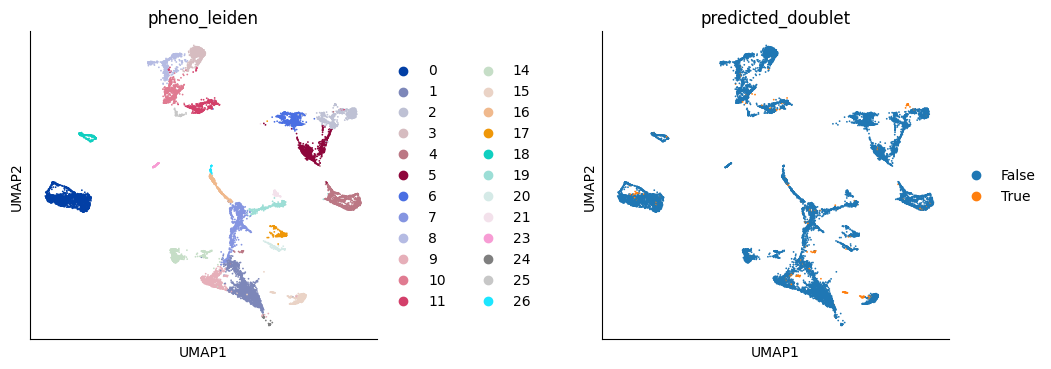

In [91]:
# Plot the UMAP embedding of the filtered data, colored by 'pheno_leiden' clusters and 'predicted_doublet' labels.
# Visualizing clusters ('pheno_leiden') alongside doublet predictions ('predicted_doublet') enables us to assess whether doublets are concentrated within specific clusters or dispersed throughout the dataset.
# This insight helps validate clustering results and ensures that doublet artifacts do not impact the biological interpretation.
# The parameter wspace=0.5 adjusts the spacing between the plots for better layout.
sc.pl.umap(adata_filtered, color=['pheno_leiden', 'predicted_doublet'], wspace=0.5)


In [92]:
# create a temporary dataframe to better visualize the percentage of doublet score. 
df_temp = pd.DataFrame({'pheno_leiden': adata_filtered.obs['pheno_leiden'], 
                        'Doublet Score': adata_filtered.obs['doublet_score']}, index = adata_filtered.obs.index)

/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/3096494409.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_91520/3096494409.py:3: UserWarning: The palette list has more values (28) than needed (24), which may not be intended.
  sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax,


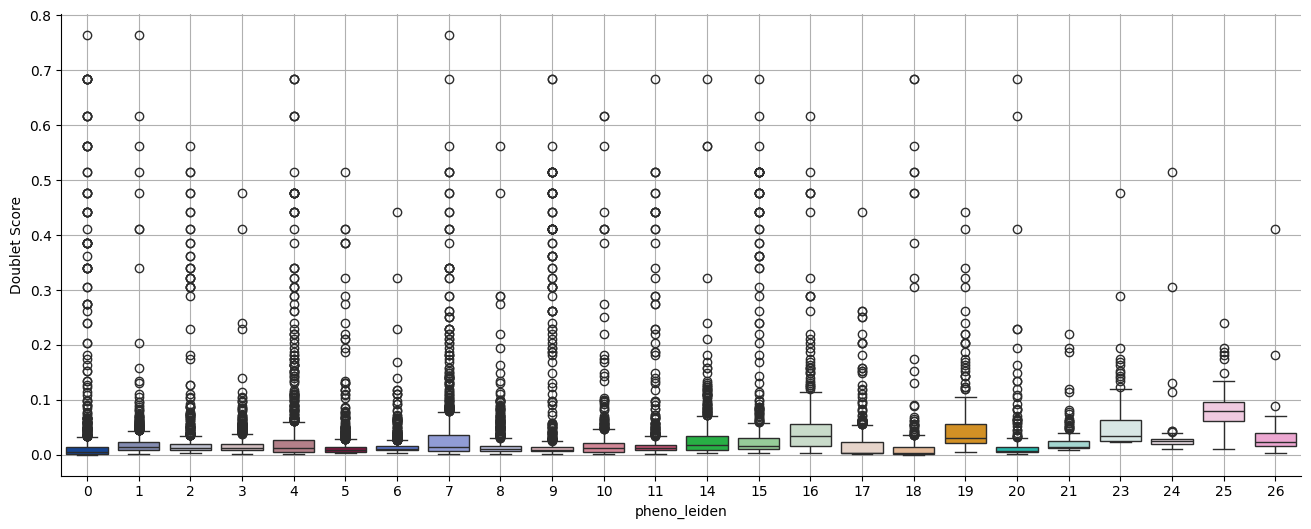

In [93]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

In [94]:
# Based on the above, we can remove cluster 25
adata_clean_rm27 = adata_filtered[~adata_filtered.obs['pheno_leiden'].isin([25]), :].copy()

In [95]:
adata_clean_rm27

AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors', 'scrublet', 'predicted_doublet_colors'
    obsm: 'X_pca', 'X_umap', 'umap_30_knn', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [96]:
adata_clean_rm27.write_h5ad('/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/processed_adata_doublet.h5ad')

## Next steps: iterate and redo preprocessing on cleaned data

In [97]:
import scipy

In [101]:
adata_clean = sc.read_h5ad('/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/processed_adata_doublet.h5ad')

In [102]:
# HVG
sc.pp.highly_variable_genes(adata_clean, layer = 'raw_data', n_top_genes=2000, flavor='seurat_v3')

# PCA
sc.tl.pca(adata_clean, n_comps=50, use_highly_variable=True)

# Neighbors
sc.pp.neighbors(adata_clean, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

# UMAP
sc.tl.umap(adata_clean, min_dist=0.1, neighbors_key='neighbors_30')

# PhenoGraph clustering
sc.external.tl.phenograph(adata_clean, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

adata_clean.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata_clean.obsp['pheno_jaccard_ig'])

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4496471881866455 seconds
Jaccard graph constructed in 2.761183023452759 seconds
Running Leiden optimization
Leiden completed in 3.444162130355835 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.8499321937561035 seconds


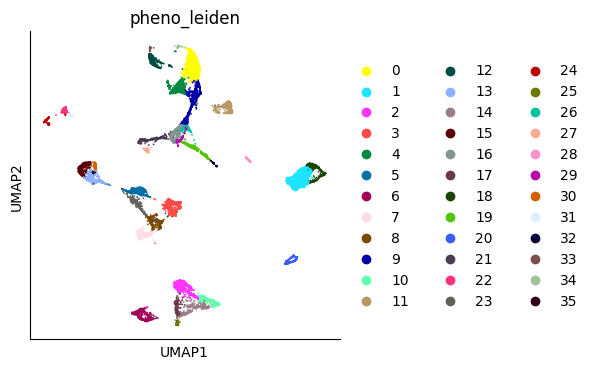

In [103]:
sc.pl.umap(adata_clean, color = ['pheno_leiden'])

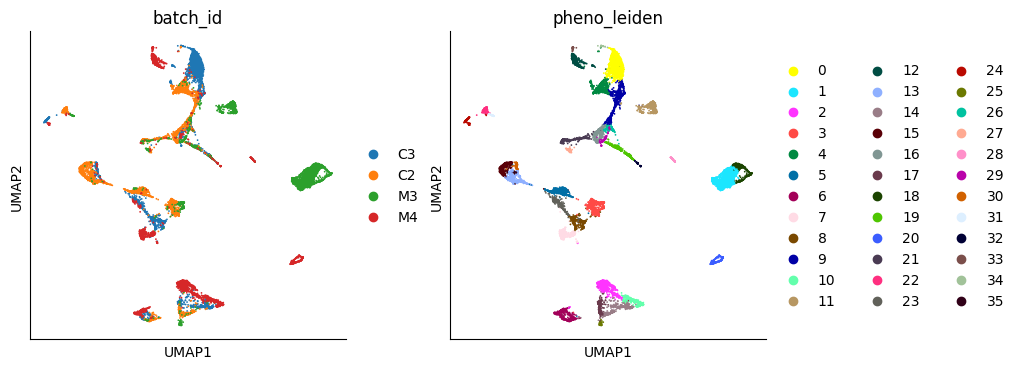

In [107]:
sc.pl.umap(adata_clean, color = ['batch_id', 'pheno_leiden'])

This UMAP plot above shows the distribution of cell clusters based on two different conditions:

Left Panel - Batch ID: The samples are color-coded by batch ID, where C3 and C2 represent healthy control samples, and M3 and M4 are MYCN-amplified samples (neuroblastoma cases). We see that cells from MYCN-amplified samples (red and green) form distinct clusters, separate from the control cells (blue and orange). This separation indicates differences in gene expression profiles between the MYCN-amplified and control samples.

Right Panel - Pheno Leiden Clustering: The cells are grouped into 36 different clusters (labeled 0-35) based on PhenoGraph clustering. Some clusters are exclusively or predominantly occupied by MYCN-amplified samples (e.g., cluster 1), while others are mostly populated by control cells. This clustering pattern suggests that certain cell types or states are more prevalent in either MYCN-amplified or control conditions, which could reflect underlying biological differences due to MYCN amplification.



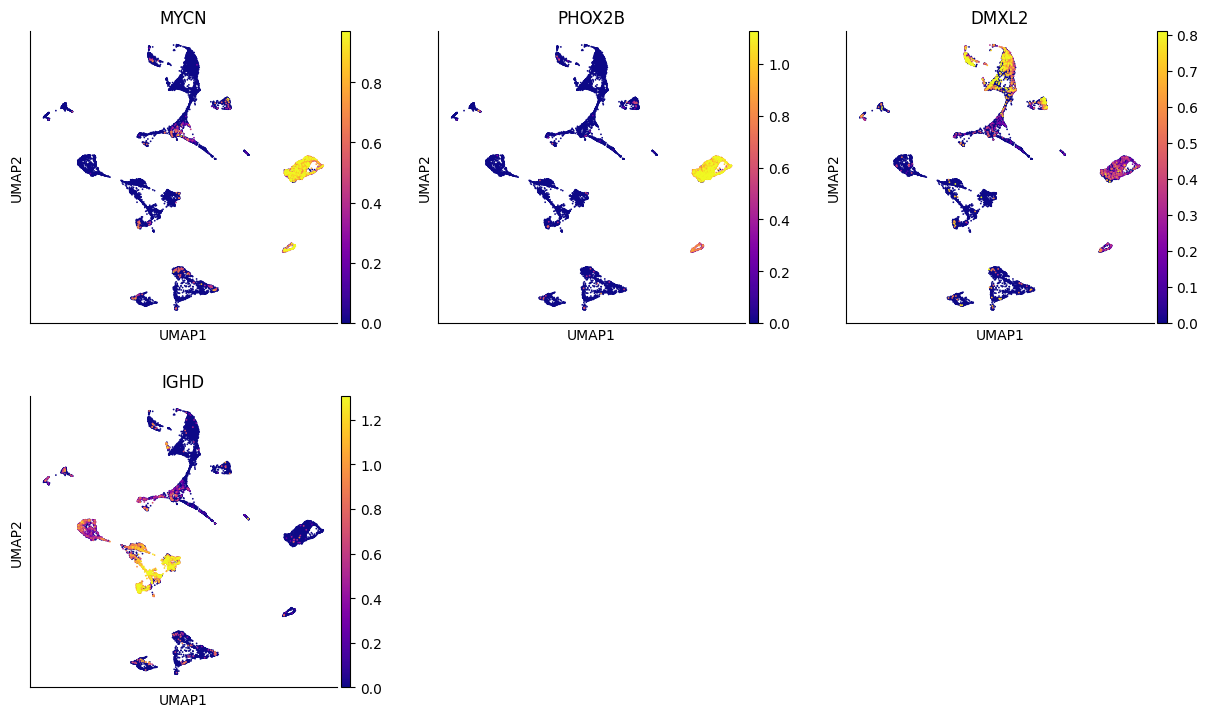

In [109]:
# Visualize expression patterns of key markers for neuroblastoma and differentiation states on UMAP
# MYCN and PHOX2B are positive markers associated with neuroblastoma cells, indicating their relevance in tumor cell identity or activity. High expression of these markers can signify MYCN amplification or neuroblastoma-specific transcriptional activity. 
# DMXL2 and IGHD are negative markers, which means they are typically not expressed in neuroblastoma cells. Their low expression can help differentiate neuroblastoma cells from non-neuroblastoma cell types or stages.
# Plotting these markers on the UMAP allows for spatial visualization of where cells with positive or negative marker expression are located in the dimensionality-reduced space. This can help identify clusters or regions enriched for neuroblastoma cells versus other cell populations within the dataset.
# Parameters: 
#   - cmap='plasma' is chosen to provide a color gradient that highlights expression levels across cells.
#   - ncols=3 organizes the plots in a compact format.
#   - vmin='p1' and vmax='p99' set the color scale to show only the 1st to 99th percentile of expression, 
#     effectively ignoring outliers and making patterns more visible.
genes = ['MYCN', 'PHOX2B', 'DMXL2', 'IGHD']
sc.pl.umap(adata_clean, color=genes, cmap='plasma', ncols=3, use_raw=False, vmin='p1', vmax='p99')


Batch-Specific Clustering:

Clusters associated with high MYCN and PHOX2B expression are likely to be more prominent in the MYCN-amplified batches (M3 and M4), whereas clusters expressing DMXL2 and IGHD are more likely found in the control batches (C2 and C3).
This batch-specific clustering pattern reinforces the separation between MYCN-amplified neuroblastoma cells and non-neuroblastoma cells in the control samples.

In [37]:

marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

Text(0, 0.5, 'Clusters')

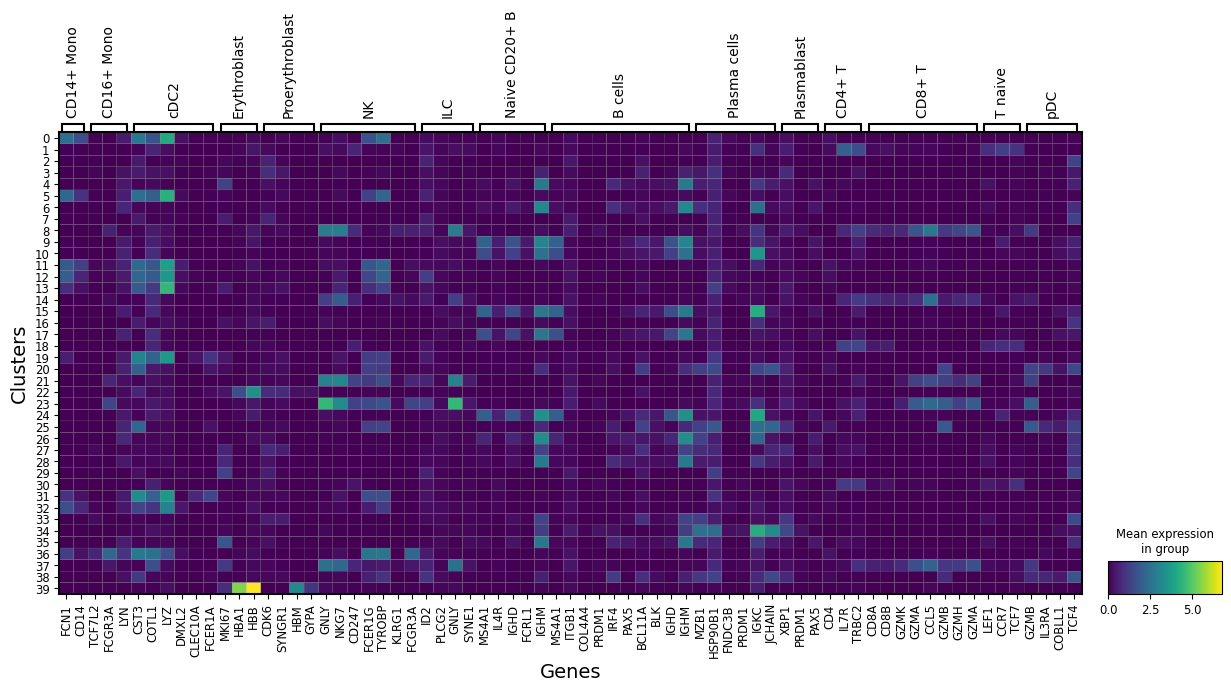

In [12]:
ax = sc.pl.matrixplot(adata_clean, marker_genes, groupby = 'pheno_leiden', show = False, figsize = (15, 6), use_raw = False)
ax['mainplot_ax'].set_xlabel('Genes', fontsize = 14)
ax['mainplot_ax'].set_ylabel('Clusters', fontsize = 14)

The above plot may not be the most illuminating. One trick is to scale the gene-expression such that the average expression goes from 0 to 1. We can do this by invoking `standard_scale` parameter in the `sc.pl.matrixplot` function.

Text(0, 0.5, 'Clusters')

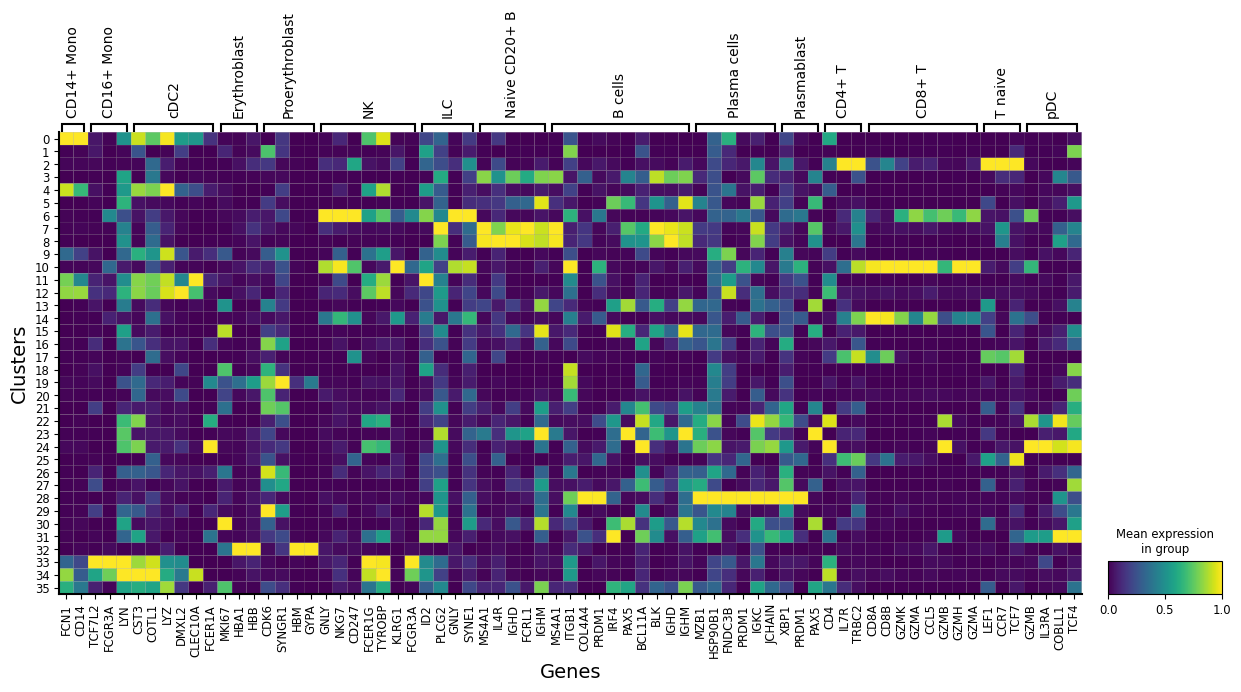

In [122]:
ac = sc.pl.matrixplot(adata_clean, marker_genes, groupby = 'pheno_leiden', show = False, figsize = (15, 6), use_raw = False, standard_scale = 'var')
ac['mainplot_ax'].set_xlabel('Genes', fontsize = 14)
ac['mainplot_ax'].set_ylabel('Clusters', fontsize = 14)

In [119]:
print(adata_clean.obs.columns)

Index(['batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo',
       'pheno_leiden', 'doublet_score', 'predicted_doublet'],
      dtype='object')


# Scanpy inbuilt diffusion maps
In the context of machine learning and high-dimensional data analysis, diffusion maps are a powerful technique for uncovering the intrinsic geometry of complex datasets. Within Scanpy, an inbuilt function enables the computation of diffusion maps, which is particularly useful for visualizing and analyzing scRNA-seq data.

Dimensionality Reduction:

Similar to techniques like PCA, t-SNE, or UMAP, diffusion maps aim to reduce the dimensionality of data. However, unlike those methods, diffusion maps capture the "connectedness" of data points, which makes them well-suited for identifying continuous trajectories and manifold structures in data.
Graph-Based Approach:

Diffusion maps use a graph-based method to represent the data, where each data point (cell) is connected to others based on similarity (e.g., gene expression similarity). This is conceptually similar to graph-based clustering techniques in machine learning, such as spectral clustering.
The method constructs a diffusion matrix, representing the likelihood of transitioning between data points, helping to capture the data's underlying structure.
Handling Non-Linear Structures:

Diffusion maps are designed to handle non-linear relationships in high-dimensional data, making them ideal for capturing the complex cellular differentiation and continuous processes that are common in single-cell datasets.

In [111]:

# Importing the Palantir library, a specialized tool for single-cell RNA-seq data analysis
# Palantir focuses on pseudotime and trajectory inference, allowing us to uncover cellular differentiation paths and states. This is particularly useful for studying developmental biology or disease progression in single-cell datasets.

import palantir

In [112]:
# Running diffusion maps using Palantir on the cleaned single-cell data.
# Diffusion maps are a dimensionality reduction technique well-suited for trajectory inference in high-dimensional single-cell RNA-seq data. 
# By focusing on 'diffusion components,' this method captures the continuous transitions between cellular states, which is useful for identifying differentiationtrajectories. Here, we're specifying 50 diffusion components to capture the nuanced variations within the data.
palantir.utils.run_diffusion_maps(adata_clean, n_components=50)


{'T': <18568x18568 sparse matrix of type '<class 'numpy.float32'>'
 	with 822924 stored elements in Compressed Sparse Row format>,
 'EigenVectors':                              0         1         2         3         4   \
 AAACCCAGTGAGTAGC-1-C3 -0.007268  0.002441  0.011270  0.001035 -0.005819   
 AAACCCAGTGTCGATT-1-C3 -0.007278  0.003224 -0.009539 -0.000439 -0.009101   
 AAACCCAGTTTCGACA-1-C3 -0.007268  0.002440  0.011240  0.001032 -0.005775   
 AAACCCATCACCCTGT-1-C3 -0.007268  0.002439  0.011191  0.001026 -0.005711   
 AAACCCATCACGGTCG-1-C3 -0.007272  0.002925 -0.005037 -0.000251  0.009061   
 ...                         ...       ...       ...       ...       ...   
 TTTGTTGAGGTGCAGT-1-M4 -0.007278  0.003240 -0.009787 -0.000453 -0.009500   
 TTTGTTGAGTAAGAGG-1-M4 -0.007278  0.003240 -0.009794 -0.000454 -0.009515   
 TTTGTTGCACGATTCA-1-M4 -0.007277  0.003235 -0.009525 -0.000430 -0.009617   
 TTTGTTGCACTCAAGT-1-M4 -0.007278  0.003238 -0.009762 -0.000452 -0.009454   
 TTTGTTGGTCCCTAAA

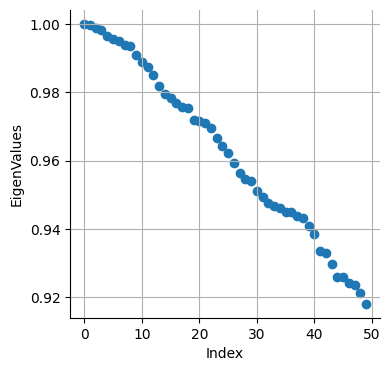

In [25]:
# Visualizing the diffusion map eigenvalues to assess their distribution.
# The eigenvalues indicate the significance of each diffusion component.
# In this plot, the x-axis represents the index of each eigenvalue (in order of importance), while the y-axis represents the magnitude of the eigenvalue.
# This visualization helps determine the number of components to retain for analysis, as a sharp drop in eigenvalues often suggests a cutoff for meaningful components.
plt.scatter(range(len(adata_clean.uns['DM_EigenValues'])), adata_clean.uns['DM_EigenValues'])
plt.xlabel('Index')
plt.ylabel('EigenValues')
plt.grid(True)


In [113]:
# Determining the multiscale space in the diffusion map using Palantir's utility function.
# This step identifies multiple scales within the data, allowing for an analysis that captures both local and global structures.
# Multiscale spaces are particularly useful for visualizing data at various resolutions, which can reveal distinct cell states or lineage trajectories in single-cell analysis.
# The function will store this multiscale space information in the AnnData object for further analysis.
palantir.utils.determine_multiscale_space(adata_clean);


In [114]:
adata_clean.obsm['DM_EigenVectors_multiscaled'].shape

(18568, 26)

In [115]:
adata_clean

AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap', 'DM_EigenValues'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'
    obsp: 'neighbors_30_connectivi

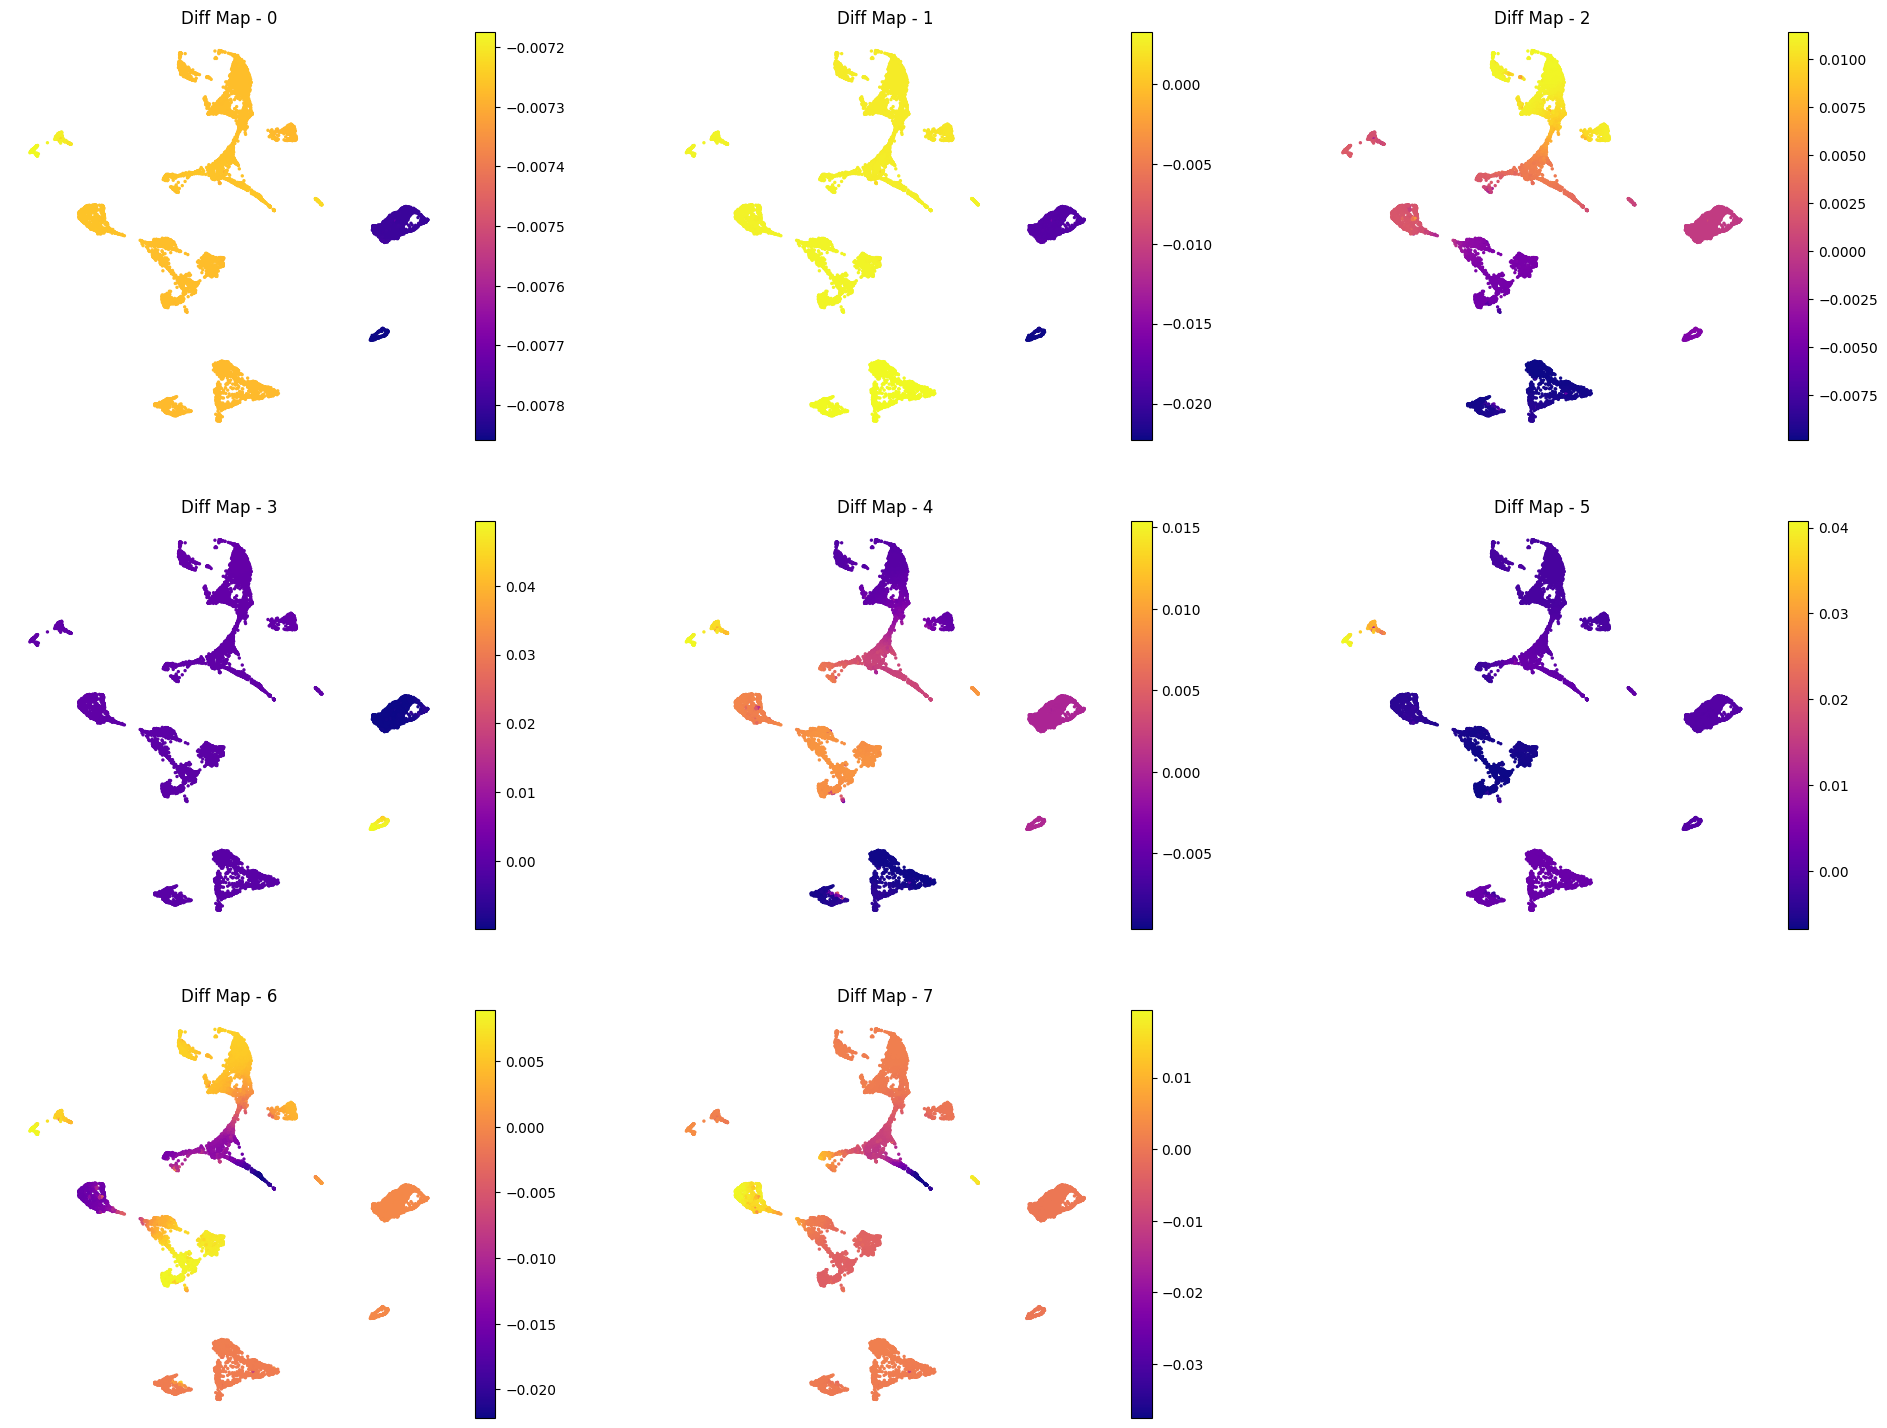

In [116]:
# Visualize the first 8 eigenvectors from the diffusion map in a UMAP embedding.
# Each plot shows a different diffusion component, which may reveal distinct cell transitions or trajectories.
# These eigenvectors help to highlight different aspects of cellular variation and can be used in pseudotime or lineage analysis.

ncol = 3
nrow = 3

fig = plt.figure(figsize=(8 * ncol, 6 * nrow))
for j in range(8):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    # Scatter plot of UMAP coordinates with coloring based on each diffusion map eigenvector
    im1 = ax.scatter(adata_clean.obsm['X_umap'][:, 0], adata_clean.obsm['X_umap'][:, 1], 
                     s=2, c=adata_clean.obsm['DM_EigenVectors'][:, j], cmap='plasma')
    fig.colorbar(im1)
    ax.axis('off')
    ax.set_title('Diffusion Map Component - ' + str(j + 1))

# Display the plot grid
plt.tight_layout()
plt.show()


This is another validation- Diffusion Map components 0 and 1 appear to capture distinct separations between the "M" (MYCN-amplified) and "C" (control) groups in this UMAP embedding. The color gradients in these components show clear spatial clustering, with "M" and "C" groups separated into distinct regions.

These diffusion components (0 and 1) likely represent the main axes of variance related to MYCN amplification status, capturing how healthy cells transition to tumor cells. 

# Cell typing. 

CellTypist is a machine learning tool designed to streamline cell type annotation in single-cell RNA sequencing data. Using a vast reference database of single-cell transcriptomes and pre-trained models, it predicts cell types based on gene expression profiles. Here’s how it works from a machine learning perspective:

Reference Dataset and Model Training: CellTypist is built on a large and diverse set of labeled single-cell data, allowing it to train classification models to recognize specific cell types. These models learn the unique expression patterns of marker genes that define different cell types.

Feature Selection and Dimensionality Reduction: Instead of analyzing the entire transcriptome, CellTypist focuses on a subset of highly informative genes. This approach reduces noise and speeds up processing, as it hones in on the most relevant gene expression patterns associated with each cell type.

Supervised Learning: CellTypist uses supervised learning, where the model is trained on labeled examples of different cell types (like T cells, B cells, and macrophages). Once trained, it applies this knowledge to classify new, unlabeled cells based on their expression profiles.

Prediction and Probability Scores: For each cell, CellTypist provides a predicted cell type along with a confidence score, indicating how strongly the model associates the cell with that type. This probability score helps assess the reliability of the predictions.

In our analysis, we began by identifying distinct patterns in control (C) and MYCN-amplified (M) samples using UMAP, which allowed us to visually separate the two groups based on overall expression profiles. This provided an initial understanding of how these samples differ in their cellular composition and clustering behavior.

Next, we zoomed into specific clusters to explore differential gene expression of key markers like MYCN, PHOX2B, DMXL2, and IGHD. By examining marker gene expression within these clusters, we could gain insights into the biological characteristics of each cluster, particularly noting positive markers for MYCN-amplified cells, which further emphasized the distinction between C and M samples.

To capture finer, continuous transitions and lineage relationships, we then employed diffusion maps. This method helped us visualize cellular trajectories and potential transitions, particularly useful for tracking cell states or differentiation paths. Diffusion maps confirmed our previous findings, reinforcing the distinct profiles between control and MYCN-amplified cells, while also revealing subtle structures and relationships among clusters.

Finally, to bring biological meaning and consistency to each cluster, we now turn to automated cell typing using CellTypist. Leveraging machine learning, CellTypist builds upon our clustering and gene expression insights, assigning well-defined cell-type labels based on extensive reference data. This step enables us to systematically annotate the clusters, providing an objective and scalable approach to define cell types across the control and MYCN-amplified samples. By completing this automated cell-typing step, we finalize our analysis pipeline with cell-type annotations that are both biologically interpretable and reproducible, transforming our data into a comprehensive cell atlas of the neuroblastoma-infiltrated bone marrow environment.

In [125]:
import celltypist
from celltypist import models

# %%
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
3,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
4,Adult_Human_Skin.pkl,cell types from human healthy adult skin
5,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
6,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice
7,Adult_Pig_Hippocampus.pkl,cell types from the adult pig hippocampus
8,Adult_RhesusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult rhesu...
9,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...


## Models and Data

CellTypist provides a variety of models avaliable to download from https://www.celltypist.org/models. As of November 3, 2023, there are 42 models avaliable. All models are for immune cells, sourced from multiple different organisms and tissues, and vary in health and diseases. Models are saved as pickle files. For more details on the context please study the metadata of each model available in the link above. For example, CellTypist was also trained on a large immune data set (see the original CellTypist paper: https://doi.org/10.1126/science.abl5197) and the model are called  Immune_All_Low.pkl and Immune_All_High.pkl. They are the same except for the granularity of the data; the Low model has 98 cell types ('low resolution') and the high model has 32 ('high resolution'). 


In [129]:
# Download the "Immune_All_Low" model for cell type annotation in neuroblastoma-infiltrated bone marrow.
# Justification: Neuroblastoma is known to infiltrate the bone marrow, where it interacts with various immune cells.
# Using an immune-focused model is suitable because it will capture the diversity of immune cell types likely present in the tumor microenvironment, allowing for an in-depth analysis of immune cell populations and their roles in neuroblastoma progression and response. Although neuroblastoma-specific models are unavailable, the immune low-resolution model provides a broad view of immune subtypes, helping us identify potential immune cell dynamics in neuroblastoma-infiltrated samples.
models.download_models(model='Immune_All_Low.pkl') # Download immune cell model for annotating immune cell types


📂 Storing models in /Users/sangeevanvellappan/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_Low.pkl (file exists)


In [130]:
adata_clean

AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap', 'DM_EigenValues'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'
    obsp: 'neighbors_30_connectivi

** Celltypist works with the raw counts so let's create a new adata which has raw counts saved in adata.raw:**

In [131]:
# Create a new AnnData object with raw gene expression data, and metadata for cells and genes.
# This serves as a copy for cell typing, preserving the original data structure.
adata_celltypist = sc.AnnData(adata_clean.layers['raw_data'], obs=adata_clean.obs, var=adata_clean.var)

# Normalize counts to a total of 10,000 per cell, standardizing across cells to mitigate library size effects.
# This ensures comparability of gene expression levels across cells.
sc.pp.normalize_total(adata_celltypist, target_sum=10000, inplace=True)

# Apply log transformation to the normalized data.
# Log transformation stabilizes variance and helps to handle the wide range of gene expression values.
sc.pp.log1p(adata_celltypist)

# Copy the UMAP coordinates from the original data, allowing visualization consistency across analyses.
# This lets us view cell typing results in the same UMAP space as our previous analyses.
adata_celltypist.obsm['X_umap'] = adata_clean.obsm['X_umap']

# Inspect the new AnnData object to confirm it includes raw data, normalized and log-transformed values, and UMAP coordinates.
# This adata object is now ready for cell typing predictions with celltypist.
adata_celltypist

AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p'
    obsm: 'X_umap'

## Annotate

In [102]:
help(celltypist.annotate)

Help on function annotate in module celltypist.annotate:

annotate(filename: Union[anndata._core.anndata.AnnData, str] = '', model: Union[str, celltypist.models.Model, NoneType] = None, transpose_input: bool = False, gene_file: Optional[str] = None, cell_file: Optional[str] = None, mode: str = 'best match', p_thres: float = 0.5, majority_voting: bool = False, over_clustering: Union[str, list, tuple, numpy.ndarray, pandas.core.series.Series, pandas.core.indexes.base.Index, NoneType] = None, min_prop: float = 0) -> celltypist.classifier.AnnotationResult
    Run the prediction and (optional) majority voting to annotate the input dataset.
    
    Parameters
    ----------
    filename
        Path to the input count matrix (supported types are csv, txt, tsv, tab and mtx) or AnnData (h5ad).
        If it's the former, a cell-by-gene format is desirable (see `transpose_input` for more information).
        Also accepts the input as an :class:`~anndata.AnnData` object already loaded in memor

In [146]:
# Run CellTypist annotation on the dataset using 'prob match' mode for more detailed probability matching.
# `mode='prob match'` instructs CellTypist to output probabilities for each possible cell type label, rather than assigning a single label.
# This mode provides a ranked list of cell type probabilities, allowing us to understand how closely each cell matches multiple cell types.
# This is especially useful in cases where cells may have mixed or ambiguous profiles, providing more granular insights into cell identity.
predictions2 = celltypist.annotate(adata_celltypist, model='Immune_All_Low.pkl', mode='prob match')

🔬 Input data has 18568 cells and 15090 genes
🔗 Matching reference genes in the model
🧬 4858 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [148]:
# Convert the CellTypist predictions into an AnnData object for easier integration with existing data.
# `predictions.to_adata()`: Converts the predictions (including cell type labels and probabilities) into an AnnData object format, which allows for seamless compatibility with Scanpy and other single-cell analysis tools.
# `adata_preds`: This new AnnData object will contain the predicted cell type annotations, enabling further analysis and visualization.
# This step allows for easy comparison of the predicted cell types with the original dataset features.
adata_preds2 = predictions2.to_adata()

adata_preds2

AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'predicted_labels', 'conf_score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'predicted_labels_colors'
    obsm: 'X_umap'

In [150]:
# Display the first 20 rows of the 'predicted_labels' and 'conf_score' columns from the adata_preds2 object.
# This preview provides an initial look at the predicted cell types and their corresponding confidence scores, allowing us to quickly assess the predictions and verify the confidence levels assigned by the model for these cells.
# This step is helpful for a quick validation check and understanding the annotation quality in the top rows of the dataset.
adata_preds2.obs[['predicted_labels', 'conf_score']].head(20)

,predicted_labels,conf_score
AAACCCAGTGAGTAGC-1-C3,Classical monocytes,0.998629
AAACCCAGTGTCGATT-1-C3,Tcm/Naive helper T cells,0.999257
AAACCCAGTTTCGACA-1-C3,Classical monocytes,0.999845
AAACCCATCACCCTGT-1-C3,Classical monocytes,0.999974
AAACCCATCACGGTCG-1-C3,Naive B cells,0.999979
AAACCCATCTCGCTTG-1-C3,Tem/Trm cytotoxic T cells,0.999995
AAACGAAAGACTCATC-1-C3,CD8a/a,0.629377
AAACGAAAGCCACCGT-1-C3,Non-classical monocytes,0.909980
AAACGAAAGTCAGAGC-1-C3,Pro-B cells,0.997112
AAACGAACAACCACGC-1-C3,CD16+ NK cells,0.999998


## Annotate at cluster level

In [151]:
# Set up a new AnnData object specifically for CellTypist predictions, starting with raw gene expression data.
# This separate object allows us to prepare the data for cell typing without modifying the original dataset.

# Create a new AnnData object using the raw data layer and carry over the metadata for cells and genes.
adata_celltypist = sc.AnnData(adata_clean.layers['raw_data'], obs=adata_clean.obs, var=adata_clean.var)

# Normalize counts to a target sum of 10,000 per cell to standardize expression levels across cells.
# This scaling step mitigates differences in library sizes, ensuring that each cell has comparable total expression.
sc.pp.normalize_total(adata_celltypist, target_sum=10000, inplace=True)

# Apply log transformation to the normalized data to stabilize variance and reduce the impact of extreme values.
# This transformation is commonly used in single-cell RNA-seq data processing to improve downstream analysis.
sc.pp.log1p(adata_celltypist)

# Copy UMAP coordinates from the original AnnData object to the new one for consistency in visualization.
# This ensures that the cell typing results can be visualized in the same UMAP space as prior analyses.
adata_celltypist.obsm['X_umap'] = adata_clean.obsm['X_umap']

# Display the prepared AnnData object to confirm it includes the expected raw data, normalization, log-transformed values, and UMAP coordinates.
# This setup readies adata_celltypist for annotation with CellTypist, ensuring a standardized data format.
adata_celltypist


AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'predicted_labels', 'conf_score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p'
    obsm: 'X_umap'

In [152]:
# Run CellTypist annotation on the preprocessed AnnData object with additional settings for majority voting and over-clustering.
# `model='Immune_All_Low.pkl'`: Specifies the pre-trained model, focusing on immune cell types at a lower resolution, which is well-suited for identifying immune populations in the neuroblastoma-infiltrated bone marrow dataset.
# `majority_voting=True`: Enables majority voting, where CellTypist assigns the most common cell type among neighbors as the predicted label, helping to reduce noise and improve robustness in predictions, especially useful in heterogeneous datasets.
# `over_clustering='pheno_leiden'`: Uses the 'pheno_leiden' clustering labels as an additional layer of information, allowing the model to consider over-clustered groups (sub-clusters) to refine predictions, which is helpful in complex immune environments.

predictions3 = celltypist.annotate(adata_celltypist, model='Immune_All_Low.pkl', majority_voting=True, over_clustering='pheno_leiden')

# Convert the CellTypist predictions to an AnnData object to integrate the predictions back into a compatible format for further analysis.
# This step creates an AnnData object containing the cell type predictions, confidence scores, and other annotations, making it straightforward to incorporate the results into the main analysis pipeline.
adata_preds3 = predictions3.to_adata()

# Display the new AnnData object containing the annotated predictions to review the structure and contents.
adata_preds3


🔬 Input data has 18568 cells and 15090 genes
🔗 Matching reference genes in the model
🧬 4858 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 18568 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'predicted_labels', 'conf_score', 'over_clustering', 'majority_voting'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p'
    obsm: 'X_umap'

In [154]:
# Display the 'predicted_labels', 'conf_score', 'over_clustering', and 'majority_voting' columns from the adata_preds3 object.
# - 'predicted_labels': Shows the assigned cell type labels for each cell, as determined by the CellTypist model.
# - 'conf_score': Provides a confidence score for each cell's prediction, indicating the model's certainty.
# - 'over_clustering': Shows the clustering label ('pheno_leiden' clusters) used for refining predictions, which helps to improve annotation accuracy by leveraging sub-cluster structure.
# - 'majority_voting': Indicates if majority voting was applied, where predictions are refined based on neighbors,enhancing prediction robustness in heterogeneous populations.
adata_preds3.obs[['predicted_labels', 'conf_score', 'over_clustering', 'majority_voting']]


,predicted_labels,conf_score,over_clustering,majority_voting
AAACCCAGTGAGTAGC-1-C3,Classical monocytes,0.984562,0,Classical monocytes
AAACCCAGTGTCGATT-1-C3,Tcm/Naive helper T cells,0.998519,17,Tcm/Naive helper T cells
AAACCCAGTTTCGACA-1-C3,Classical monocytes,0.999070,0,Classical monocytes
AAACCCATCACCCTGT-1-C3,Classical monocytes,0.999738,0,Classical monocytes
AAACCCATCACGGTCG-1-C3,Naive B cells,0.999885,8,Naive B cells
...,...,...,...,...
TTTGTTGAGGTGCAGT-1-M4,Tcm/Naive cytotoxic T cells,0.992894,2,Tcm/Naive helper T cells
TTTGTTGAGTAAGAGG-1-M4,Tcm/Naive helper T cells,0.999963,2,Tcm/Naive helper T cells
TTTGTTGCACGATTCA-1-M4,Tem/Temra cytotoxic T cells,0.999978,10,Tem/Temra cytotoxic T cells
TTTGTTGCACTCAAGT-1-M4,Tcm/Naive helper T cells,0.997021,2,Tcm/Naive helper T cells


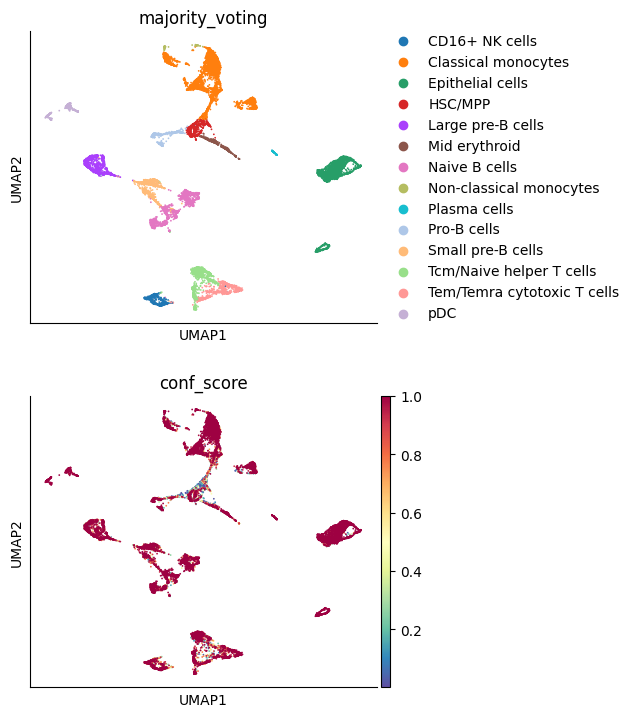

In [155]:
# Plot the UMAP embedding of cells, colored by 'majority_voting' and 'conf_score' for each cell.
# - 'majority_voting': This plot shows whether majority voting was applied to refine each cell's label, which helps visualize areas where neighborhood-based refinement influenced predictions.
# - 'conf_score': Displays the confidence scores for each prediction, allowing us to observe the distribution of confidence levels across the UMAP. This is useful for identifying regions with lower confidence, where predictions may be less certain.
# Setting 'ncols=1' arranges the plots in a single column for easier comparison.
sc.pl.umap(adata_preds3, color=['majority_voting', 'conf_score'], ncols=1)


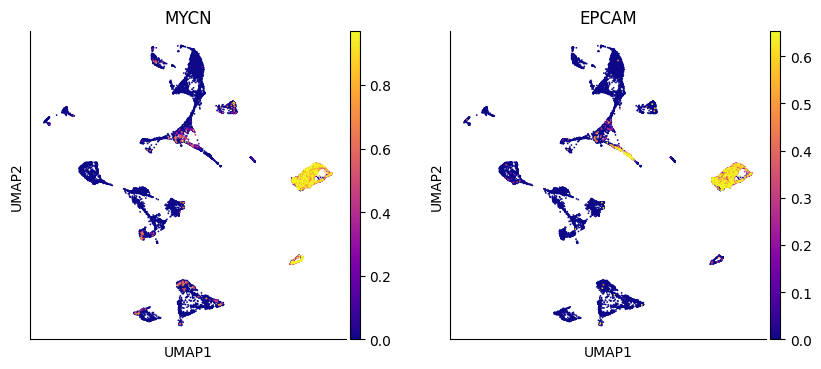

In [157]:
# Visualize the expression levels of specific genes on the UMAP to assess their distribution across cells.
# `genes = ['MYCN', 'EPCAM']`: These genes were chosen for their relevance:
#   - MYCN: A key marker often amplified in neuroblastoma, used to identify neuroblastoma cells or tumor-specific clusters.
#   - EPCAM: A marker for epithelial cells, useful for identifying epithelial-like or tumor-derived cells.
#  - since the cluster that had MYCN-amplified is predicted to contain epithelial cells in the above plot, let's verify if epithelial cells and MYCN are indeed present in the cluster. 
# This plot will help to visualize the spatial expression patterns of these genes on the UMAP, highlighting where neuroblastoma or epithelial-like cells might cluster. 
# Parameters:
#   - `cmap='plasma'`: Uses the plasma color map to indicate expression levels.
#   - `ncols=3`: Arranges the plots in a grid of up to 3 columns, providing a compact layout.
#   - `use_raw=False`: Uses the preprocessed data instead of raw counts.
#   - `vmin='p1'` and `vmax='p99'`: Limits color scaling to the 1st and 99th percentiles, making patterns more visible by reducing outlier effects.
genes = ['MYCN', 'EPCAM']
sc.pl.umap(adata_clean, color=genes, cmap='plasma', ncols=3, use_raw=False, vmin='p1', vmax='p99')


In this UMAP visualization, MYCN and EPCAM expression patterns are shown across cell clusters. MYCN, a marker often associated with neuroblastoma, shows prominent expression in clusters linked to MYCN-amplified samples, which is expected in neuroblastoma contexts. EPCAM, an epithelial cell marker, also appears in the same clusters, suggesting the presence of epithelial-like characteristics within these cells, possibly due to the tumor microenvironment or cellular plasticity in neuroblastoma cells. Neuroblastoma cells can sometimes express epithelial markers, especially if they undergo partial epithelial-to-mesenchymal transition (EMT) or if they are in close interaction with epithelial cells, leading to a mixed phenotype.

The co-expression of MYCN and EPCAM in these clusters has significant implications for both clinical diagnosis and drug discovery. For clinicians, identifying MYCN amplification alongside epithelial markers like EPCAM could refine diagnostic criteria, helping to distinguish aggressive MYCN-amplified neuroblastoma from other cell types. This insight could also aid in assessing tumor heterogeneity and in tailoring treatment approaches based on the presence of specific markers. For drug discovery, the mixed phenotype observed here highlights potential therapeutic targets within the tumor microenvironment. Drugs designed to inhibit MYCN-driven tumor proliferation or to disrupt the interaction between neuroblastoma and epithelial-like cells could be especially effective. Understanding these co-expression patterns thus offers a dual advantage: it supports precision medicine in diagnosis and guides the development of targeted therapies for more effective treatment.

In [119]:
adata_clean

AnnData object with n_obs × n_vars = 20287 × 16639
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'predicted_labels', 'conf_score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap', 'DM_EigenValues'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'


In [158]:
adata_clean.write_h5ad('/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/processed_adata_with_clusters.h5ad')